In [1]:
!pip install torch pandas matplotlib optuna graphviz
try:
    dbutils.library.restartPython()
except NameError:
    print("dbutils not found")

dbutils not found


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from pandas.plotting import radviz
import matplotlib.image as mpimg
import optuna
import urllib.request;
import pickle
from pathlib import Path
import graphviz
RESOURCES_DIR = "./resources/"

# Embedding space - sparse vs dense

In [3]:
text = """But these new vectors are a big pain: you could think of thousands of different semantic attributes that might be relevant to determining similarity, and how on earth would you set the values of the different attributes? Central to the idea of deep learning is that the neural network learns representations of the features, rather than requiring the programmer to design them herself. So why not just let the word embeddings be parameters in our model, and then be updated during training? This is exactly what we will do. We will have some latent semantic attributes that the network can, in principle, learn. Note that the word embeddings will probably not be interpretable. That is, although with our hand-crafted vectors above we can see that mathematicians and physicists are similar in that they both like coffee, if we allow a neural network to learn the embeddings and see that both mathematicians and physicists have a large value in the second dimension, it is not clear what that means. They are similar in some latent semantic dimension, but this probably has no interpretation to us."""

# Build vocabulary out of unique words
vocab = list(set(text.split()))
vocab_size = len(vocab)
print(vocab)

['vectors', 'interpretable.', 'them', 'we', 'training?', 'learn.', 'think', 'just', 'and', 'So', 'above', 'these', 'representations', 'new', 'means.', 'in', 'model,', 'learns', 'updated', 'herself.', 'mathematicians', 'do.', 'could', 'why', 'design', 'pain:', 'but', 'like', 'can,', 'it', 'how', 'some', 'would', 'allow', 'They', 'is,', 'both', 'semantic', 'on', 'probably', 'network', 'than', 'relevant', 'be', 'will', 'physicists', 'a', 'second', 'let', 'Central', 'our', 'similar', 'different', 'might', 'latent', 'of', 'us.', 'during', 'not', 'see', 'to', 'learning', 'what', 'values', 'attributes', 'is', 'are', 'attributes?', 'can', 'But', 'idea', 'neural', 'interpretation', 'Note', 'earth', 'This', 'hand-crafted', 'although', 'determining', 'features,', 'has', 'the', 'dimension,', 'programmer', 'parameters', 'they', 'this', 'similarity,', 'embeddings', 'learn', 'clear', 'requiring', 'We', 'principle,', 'that', 'That', 'value', 'you', 'big', 'with', 'word', 'thousands', 'exactly', 'set',

#### One-hot embedding

In [4]:
vocab_dict = {word: id for id, word in enumerate(vocab)}
print(vocab_dict)

one_hot_embed = torch.eye(len(vocab_dict), len(vocab_dict))
print(one_hot_embed, one_hot_embed.size())

def one_hot(x):
    return one_hot_embed[vocab_dict[x]]

x = 'mathematicians'
y = one_hot(x)
print(y)


{'vectors': 0, 'interpretable.': 1, 'them': 2, 'we': 3, 'training?': 4, 'learn.': 5, 'think': 6, 'just': 7, 'and': 8, 'So': 9, 'above': 10, 'these': 11, 'representations': 12, 'new': 13, 'means.': 14, 'in': 15, 'model,': 16, 'learns': 17, 'updated': 18, 'herself.': 19, 'mathematicians': 20, 'do.': 21, 'could': 22, 'why': 23, 'design': 24, 'pain:': 25, 'but': 26, 'like': 27, 'can,': 28, 'it': 29, 'how': 30, 'some': 31, 'would': 32, 'allow': 33, 'They': 34, 'is,': 35, 'both': 36, 'semantic': 37, 'on': 38, 'probably': 39, 'network': 40, 'than': 41, 'relevant': 42, 'be': 43, 'will': 44, 'physicists': 45, 'a': 46, 'second': 47, 'let': 48, 'Central': 49, 'our': 50, 'similar': 51, 'different': 52, 'might': 53, 'latent': 54, 'of': 55, 'us.': 56, 'during': 57, 'not': 58, 'see': 59, 'to': 60, 'learning': 61, 'what': 62, 'values': 63, 'attributes': 64, 'is': 65, 'are': 66, 'attributes?': 67, 'can': 68, 'But': 69, 'idea': 70, 'neural': 71, 'interpretation': 72, 'Note': 73, 'earth': 74, 'This': 75,

One-hot is a lookup table that has a distinct dimension for each word in a vocabulary - it's sparse in a sense that every word is isolated from others.


#### Dense embedding space

Sparse embedding space is a poor way to displaying relationship between elements - they are izolated from each other. If you want to represent meaningfull connections between the words, you want to create a shared space for all of them.

In [5]:
# Dummy embedding model
class dense_embedding_model(nn.Module):
    def __init__(self, vocab_size, dims):
        super().__init__()
        self.embed_table = torch.randn(vocab_size, dims)

    def forward(self, word):
        return self.embed_table[word]

# Helping functions
def word_to_int(word, vocab):
    return vocab[word]

def word_to_tensor(word, vocab):
    return torch.tensor(vocab[word]).reshape(1)

def words_to_tensors(words, vocab):
    ints = []
    for word in words:
        ints.append(word_to_int(word, vocab))
    return torch.tensor(ints)


# Initiate model
dims = 5
torch.manual_seed(69)
embed_model = dense_embedding_model(vocab_size, dims)


In [6]:
# Print embeddings for example words
example_words = ['mathematicians', 'and', 'physicists', 'can', 'learn']
example_words_ints = words_to_tensors(example_words, vocab_dict)

y = embed_model(example_words_ints)

for word, emb in zip(example_words, y):
    print(f'{word}: {emb}')


mathematicians: tensor([ 0.7329, -0.7448,  2.2900,  0.1214, -1.3227])
and: tensor([-0.4807, -1.4154,  0.0934, -0.2420, -1.0300])
physicists: tensor([ 0.3899,  2.0513,  0.7494,  1.2193, -1.6536])
can: tensor([ 2.8145,  0.0074,  0.8381, -0.4500, -0.2197])
learn: tensor([-1.0601,  0.9692, -1.7794, -1.1826,  0.6452])


In [7]:
# Print full embedding space
words_ints = words_to_tensors(vocab, vocab_dict)
complete_space = embed_model(words_ints)

df = pd.DataFrame([{"name": name, "id": i} for name, i in vocab_dict.items()])

for embed_dim in range(complete_space.size(dim=1)):
    df[f"embed_dim_{embed_dim}"] = complete_space[:, embed_dim]

df

,name,id,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3,embed_dim_4
0,vectors,0,-0.530009,-1.303516,0.443812,1.222124,1.039550
1,interpretable.,1,0.960848,0.421351,0.745207,-1.838907,-1.249664
2,them,2,-0.248462,0.142757,-1.050944,0.352695,-0.091552
3,we,3,0.034143,-0.898591,0.102156,-0.662733,-0.134987
4,training?,4,-0.398346,-1.789197,1.278515,1.335117,-0.306642
...,...,...,...,...,...,...,...
107,if,107,0.301581,-0.691899,0.539687,-0.955405,1.269264
108,have,108,2.185326,-0.769757,-0.464975,1.314414,0.851996
109,rather,109,-0.687948,0.036470,0.992726,0.008702,1.918367
110,deep,110,0.051825,-0.661604,-0.190305,-0.093521,2.100532


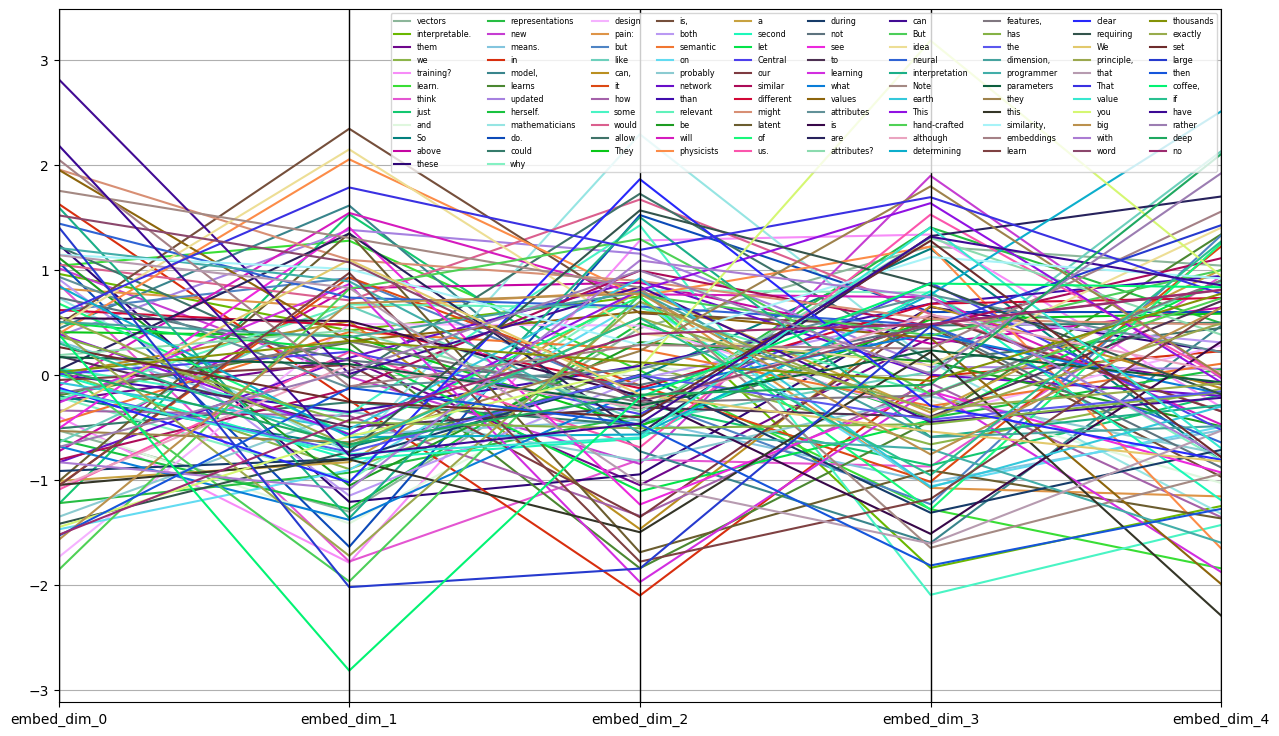

In [8]:
plt.figure(figsize=(15, 9))  # Adjust the width and height as needed
parallel_coordinates(df.drop("id", axis=1), "name")
plt.legend(fontsize='xx-small', ncol=10)
plt.show()

So, one can thing about the embeddings as words being represented in multiple dimensions.  
In above example there's no correlation between them - obviously - we initiated embeddings for each word randomly.  


## Dimensions as similarities

Ideally we want the embeddings represent something meaningfull - in similar way as we can see certain features of things when analysing real life data and recognize similarities and differences.   
For example here we have 3 species of Irises.

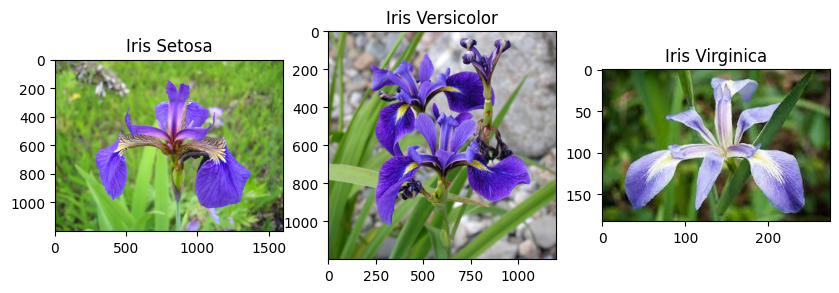

In [9]:
fig = plt.figure(figsize=(10, 7))
img0 = mpimg.imread(RESOURCES_DIR + 'iris-setosa.jpeg')
img1 = mpimg.imread(RESOURCES_DIR + 'iris-versicolor.jpeg')
img2 = mpimg.imread(RESOURCES_DIR + 'iris-virginica.jpeg')
fig.add_subplot(1, 3, 1)
plt.imshow(img0)
plt.title("Iris Setosa")
fig.add_subplot(1, 3, 2)
plt.imshow(img1)
plt.title("Iris Versicolor")
fig.add_subplot(1, 3, 3)
plt.imshow(img2)
plt.title("Iris Virginica")
plt.show()

When we plot parameters of each individual of iris from dataset as separate dimensions, we notice the differences between the *categories* and similarities between *individuals*.

<Axes: >

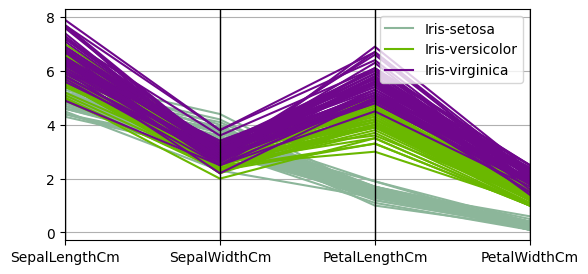

In [10]:
# Similarities between individuals of Irises in 4 dimensions
fig = plt.figure(figsize=(6, 3))
iris = pd.read_csv(RESOURCES_DIR + 'Iris.csv')
parallel_coordinates(iris.drop("Id", axis=1), "Species")

Different species of Iris are similar to each other, but individuals are more similar among themselves and this can be seen in 4 dimensions: SepalLength, Sepal Width, Petal Length and Petal Width.  
It would be wonderful if we could achieve something similar in language - to represent some relationship between them.  
Not necessarily similarity between words per say, but to associate semantic meaning between them.  

# Word2Vec

This is what we can achieve by training embeddings in special way.  
Word2Vec is one of methods to achieve this.  
Additionally to defined embeddings layer as we did in **Dense embedding space** example, we add additional linear layer with outputs of same size as inputs.  
This architecture will allow us to define a feedback loop between input words and output (predicted) words.  

## Model definition

In [11]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, batch_size, seed):
        super().__init__()
        torch.manual_seed(seed)
        # layers
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        # save parameters for later
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        print(f"[model] embed_layer size: {vocab_size}-> {embedding_dim}")
        print(f"[model] linear1 size: {embedding_dim}-> {vocab_size}")

    def forward(self, inputs):
        embed = self.embedding_layer(inputs)
        embed_sum = torch.sum(embed, dim=1)
        logits = self.linear1(embed_sum)
        logits = F.relu(logits)
        logits = self.linear2(logits)
        out = F.softmax(logits, dim=1)
        return out

    def get_embed(self, inputs):
        embed = self.embedding_layer(inputs)
        return embed

def train(dataloader, model, loss_fn, optimizer, epochs, batch_size, device, print_every=10, debug=False):
    model.train()

    losses = []
    for epoch in range(epochs):
        if debug: print(f"[train] Epoch: {epoch}/{epochs}")
        total_loss = 0

        for inputs, output in dataloader:
            inputs = inputs.to(device)
            output = output.reshape(-1,).to(device)
            if debug: print(f"[train] inputs: {inputs.size()}, type: {inputs.type()}")
            if debug: print(f"[train] output: {output.size()}, type: {output.type()}")
            if (inputs_size:=inputs.size(dim=0)) != batch_size:
                print(f"[train] inputs size ({inputs_size}) not equal to batch size ({batch_size}) - last batch?? skipping")
                continue
            optimizer.zero_grad()
            pred = model(inputs)
            if debug: print(f"[train] pred: {pred.size()}, type: {pred.type()}")

            loss = loss_fn(pred, output)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch%print_every == 0:
            print(f"[train] Epoch {epoch} - loss: {loss.item()}")

        losses.append(total_loss)

    return model, losses


In practice the model is trained to minimize $Loss$ based on prediction of the middle word from surrounding ones. See below gif to get the idea behind it.

In [12]:
# It takes ~35 seconds to generate the gif on Intel i7 with 16 GB Ram
# Otherwise the gif is already generated and can be found in the resources folder
# Also open gif separately, notebook doesn't load gifs
def generate_animation():
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from visualize_embedding_layers import draw_pipeline
    BGCOLOR="black"
    fig, ax = plt.subplots(figsize=(16, 9))
    fig.set_facecolor(BGCOLOR)

    def update(frame):
        plt.cla()
        fig.set_facecolor(BGCOLOR)
        ax.axis('off')
        draw_pipeline(text=text,
                        word_start_id=frame,
                        context_window_size=5,
                        embed_dims=3,
                        ax=ax,
                        bgcolor=BGCOLOR)

    ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=100)
    writer = animation.PillowWriter(fps=1)
    ani.save(RESOURCES_DIR + 'model_training_scheme.gif', writer=writer)

# Uncomment below if you want to see directly or play with parameters - it will render animation here in notebook,
# otherwise in markdown cell below is same gif preloaded from file when notebook is started
# I commented generator out, because it doesn't render well in Github/Jupyter (also it takes long time to generate each time)
#generate_animation()

Below is training loop demonstration (see comment above if you want to change it).

![training gif](./resources/model_training_scheme.gif "segment")

## Dataset definition

In [13]:
class CBOWTrainingDataset(Dataset):
    def word_to_tensor(self, word, vocab):
        return torch.tensor(vocab[word]).reshape(1)

    def word_to_one_hot(self, word, vocab):
        return self.one_hot_table[vocab[word]]

    def build_ds(self, words):
        targets, contexts = None, None
        for i in range(self.half_context_size, self.text_size-self.half_context_size):
            context_left = torch.vstack([self.word_to_tensor(words[i - j - 1],
                                                        self.vocab_dict) for j in range(self.half_context_size)])
            context_right = torch.vstack([self.word_to_tensor(words[i + j + 1],
                                                        self.vocab_dict) for j in range(self.half_context_size)])
            context = torch.vstack((context_left, context_right)).to(torch.long)

            target = self.vocab_dict[words[i]]
            target = torch.tensor(target, dtype=torch.long).reshape(1,)

            if contexts is None:
                contexts = context.reshape(1, self.context_size)#, self.vocab_size)
                targets = target
            else:
                contexts = torch.vstack((contexts, context.reshape(1, self.context_size)))#, self.vocab_size)))
                targets = torch.vstack((targets, target))

        print(f"[DS] Last text word id: {i}")
        print(f"[DS] contexts: {contexts.size()}, type: {contexts.type()}")
        print(f"[DS] targets: {targets.size()}, type: {targets.type()}")
        print(f"[DS] vocab_size: {self.vocab_size}")
        return contexts, targets


    def __init__(self, words, context_size, dtype=torch.float32):
        self.text_size = len(words)
        print(f"[DS] text size: {self.text_size}")
        self.dtype = dtype
        self.context_size = int(context_size)
        self.half_context_size = int(context_size/2)
        vocab = list(set(words))
        self.vocab_size = len(vocab)
        self.vocab_dict = {name: i for i, name in enumerate(vocab)}
        # one-hot table to generate vocab-size targets
        self.one_hot_table = torch.eye(self.vocab_size, self.vocab_size)

        #build_ds = jax.jit(self.build_ds_jax)
        build_ds = self.build_ds
        self.contexts, self.targets = build_ds(words)


    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, idx):
        # inputs are (text_size-context_size)/context_size/int
        # targets are (text_size-context_size)/1/vocab_size
        context = self.contexts[idx]
        target = self.targets[idx]
        return context, target

### Dataset text source

In [14]:
text_sources = ["shapespeare", "The Three Little Pigs"]
# pick one of above
text_source = "The Three Little Pigs"

if text_source == "shakespeare":
    text_url = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
    text_file = "shakespeare.txt"
    text_words_file = "text_words.pkl"
    text_size = 10_004

    if Path(text_words_file).exists():
        with open(text_words_file, "rb") as file:
            text_words = pickle.load(file)
    else:
        urllib.request.urlretrieve(text_url, text_file)
        with open(file=text_file, mode='r') as file:
            text = file.read()
            # split
            text_words = list(text.split())
            # save for quick retrieval
            with open(text_words_file, 'wb') as file:
                pickle.dump(text_words, file)

    text_words = text_words[:text_size]

    probe_word = "lartius"


elif text_source == "The Three Little Pigs":
    text = """
                        The Three Little Pigs
                        ---------------------
                        Once upon a time
                        there was a family of three little pigs
                            *oink sound effect*
                        one little pig lived in a house of straw
                        another little pig lived in a house of wood
                        the third little pig lived in a house of brick
                        But then there came along a big bad wolf.
                            *howling wolf*
                        The wolf went knocking on the first pig's door
                        "Little pig, little pig," he said.  "let me come in!"
                        "Not by the hairs on my chinny chin chin." the first pig said.
                        "Then I'll huff, and I'll puff, and I'll blow your house in," said the wolf.
                        So he huffed, and he puffed,
                            *wind sound effect*
                        and he blew the house down and ate the little pig right up.
                        The next day, the big bad wolf came knocking on the second pig's door.
                            *knock sound effect*
                        "Little pig, little pig," he said, "let me come in!"
                        "Not by the hairs on my chinny chin chin," the second pig said.
                        "Then I'll huff and I'll puff, and I'll blow your house in," said the wolf.
                        So he huffed and he puffed,
                            *wind sound effect*
                        and he blew the house down, and ate the little pig right up.
                        The next day, the big bad wolf came knocking on the third pig's door.
                        "Little pig, little pig," he said, "let me come in!"
                        "Not by the hairs on my chinny chin chin," the third pig said.
                        "Then I'll huff and I'll puff, and I'll blow your house in," said the wolf.
                        So he huffed and he puffed,
                            *wind sound effect*
                        but the house of bricks would not fall.
                        The wolf went home and thought about how to trick the third little pig.
                        The next day, the big bad wolf came knocking on the door again.
                        "Ho ho ho," he said. "It's me, Santa Claus! I have presents!"
                        "If you are really Santa, then come down my chimney chim chim," the third pig said.
                        So he jumped up on the roof and climbed in the chimney.
                        But the third little pig knew it was the wolf, and put a pot of hot water under the chimney.
                        Down the wolf came, straight into the water, and got cooked right up.
                            *screaming, burning alive sound effect*
                        As the pig began to feast on his wolf dinner, his brothers jumped out and they were reunited.
                        And the three little pigs lived happily ever after.
                            *music*

                    """
    text_words = list(text.split())
    probe_word = "wolf"

else:
    raise ValueError(f"text {text_source} not found, expected one of {text_sources}.")

text_words = [word.lower() for word in text_words if word.isalpha()]
print(f"test len: {len(text_words)}, first 10 words: {text_words[:10]}")


test len: 303, first 10 words: ['the', 'three', 'little', 'pigs', 'once', 'upon', 'a', 'time', 'there', 'was']


## Grid search for optimal params.

In [15]:
def objective(trial):
    # Set hyperparameters
    embed_dim = trial.suggest_int('embed_dim', 5, 55, step=10)
    learning_rate = trial.suggest_float('lr', 1e-3, 1, log=True)
    #epochs = trial.suggest_int('epochs', 1, 2)
    epochs = 2
    half_context_size = trial.suggest_int('half_context_size', 2, 5)
    context_size = 2*half_context_size
    #batch_size = trial.suggest_int('batch_size', 1000, max(2000, min(4000, len(text_words)-context_size)))
    batch_size = trial.suggest_int('batch_size', 10, 1000)
    seed = trial.suggest_int('seed', 70, 75)

    device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(device)

    # Build training list for Word2Vec Continuous Bag-of-Words method
    print(f"[objective] batch_size: {batch_size}")
    print(f"[objective] embed_dim: {embed_dim}")
    print(f"[objective] context size: {context_size}")

    if context_size in datasets:
        dataset = datasets[context_size]
    else:
        dataset = CBOWTrainingDataset(text_words, context_size)
        datasets[context_size] = dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Verify sizes
    for context, target in dataloader:
        print(f"[objective] context: {context.size()}, \ntarget: {target.size()}, \nvocab_size: {dataset.vocab_size}")
        break


    # Define model, loss function and optimizer
    model = CBOW(dataset.vocab_size, embedding_dim=embed_dim, context_size=context_size, batch_size=batch_size, seed=seed)
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    _, losses = train(dataloader=dataloader,
                   model=model,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   epochs=epochs,
                   batch_size=batch_size,
                   device=device)

    return losses[-1]


## Run grid search and/or training

mps
[objective] batch_size: 297
[objective] embed_dim: 3
[objective] context size: 6
[DS] text size: 303
[DS] Last text word id: 299
[DS] contexts: torch.Size([297, 6]), type: torch.LongTensor
[DS] targets: torch.Size([297, 1]), type: torch.LongTensor
[DS] vocab_size: 101
[objective] context: torch.Size([297, 6]), 
target: torch.Size([297, 1]), 
vocab_size: 101
[model] embed_layer size: 101-> 3
[model] linear1 size: 3-> 101
[train] Epoch 0 - loss: 4.615617275238037
[train] Epoch 20 - loss: 4.338688850402832
[train] Epoch 40 - loss: 4.3215556144714355
[train] Epoch 60 - loss: 4.317800521850586
[train] Epoch 80 - loss: 4.317387104034424
[train] Epoch 100 - loss: 4.317192077636719
[train] Epoch 120 - loss: 4.317075252532959
[train] Epoch 140 - loss: 4.317017078399658
[train] Epoch 160 - loss: 4.316962718963623
[train] Epoch 180 - loss: 4.3169145584106445
Loss after last epoch: 4.316878318786621


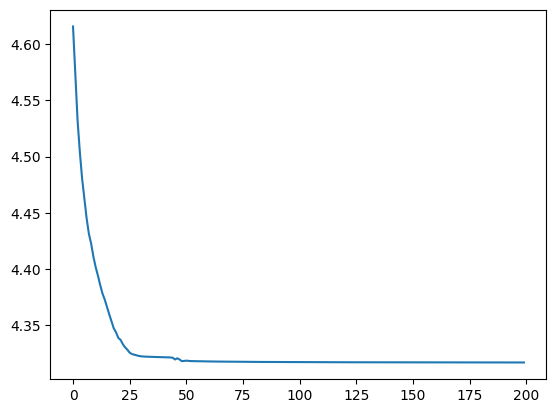

In [16]:
# Grid search is very long, it looks for optimal hyperparameters
grid_seach_mode = False

# datasets dict with context_size as key and CBOWTrainingDataset instance for that context size as value - they are reused in the optuna trials or during final training
datasets = {}
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

if grid_seach_mode:
    # Optuna study for hyperparameter optimization
    study = optuna.create_study(storage="sqlite:///db.sqlite3",
                                study_name="Embeddings-similarity2",
                                direction="minimize",
                                load_if_exists = True)
    study.optimize(objective, n_trials=100)

    print(f"Best value: {study.best_value} (params: {study.best_params})")
    embed_dim = study.best_params['embed_dim']
    lr = study.best_params['lr']
    context_size = 2*study.best_params['half_context_size']
    batch_size = study.best_params['batch_size']
    seed = study.best_params['seed']

else:
    # Once you found optimal parameters disable grid_search_mode and set below to optimal
    embed_dim=3
    lr=0.026727287161114725
    context_size=6
    batch_size=len(text_words)-context_size
    seed=73

epochs = 200


# Build training list for Word2Vec Continuous Bag-of-Words method
print(f"[objective] batch_size: {batch_size}")
print(f"[objective] embed_dim: {embed_dim}")
print(f"[objective] context size: {context_size}")

if context_size in datasets:
    dataset = datasets[context_size]
else:
    dataset = CBOWTrainingDataset(text_words, context_size)
    datasets[context_size] = dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Verify sizes
for context, target in dataloader:
    print(f"[objective] context: {context.size()}, \ntarget: {target.size()}, \nvocab_size: {dataset.vocab_size}")
    break


# Define model, loss function and optimizer
model = CBOW(dataset.vocab_size, embedding_dim=embed_dim, context_size=context_size, batch_size=batch_size, seed=seed)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training
model, losses = train(dataloader=dataloader,
                model=model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=epochs,
                batch_size=batch_size,
                device=device,
                print_every=epochs//10,
                debug=False
              )

# Display performance
plt.plot(losses)
print(f"Loss after last epoch: {losses[-1]}")


#### Prepare vocab dictionary for embeddings visualization

In [17]:
model.eval()

presentation_vocab_dict = dataset.vocab_dict
presentation_reverse_vocab_dict = {i: name for name, i in presentation_vocab_dict.items()}

dict_words = []
presentation_vocab = list(set(text_words[:10000]))
for id, word in enumerate(presentation_vocab):
    word_id = torch.tensor(presentation_vocab_dict[word]).to(device)
    embed = model.get_embed(word_id)
    # append
    dict_row = {"id": id, "word": word, "raw_embed": embed}
    dict_row.update({f"dim_{dim_id}": dim_val.item() for dim_id, dim_val in enumerate(embed)})
    dict_words.append(dict_row)



#### Define word-to-embedding functions

In [18]:
df_words = pd.DataFrame.from_dict(dict_words)

def word_to_embed(word):
    return dict_words[presentation_vocab_dict[word]]["raw_embed"]

def embed_to_word(embed):
    return [record for record in dict_words if torch.equal(record.get("raw_embed"), embed)][0]["word"]

# Test functions - transpose first embedding to word and back
assert(text_words[0] == embed_to_word(word_to_embed(text_words[0])))

In [19]:
# eval for random sentence
dataset = CBOWTrainingDataset(text_words, context_size)
datasets[context_size] = dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
input, target = next(iter(dataloader))
input = input.to(device)
pred = model(input)
print("prediction: ", torch.argmax(pred).item(), "target: ", target.item())

[DS] text size: 303
[DS] Last text word id: 299
[DS] contexts: torch.Size([297, 6]), type: torch.LongTensor
[DS] targets: torch.Size([297, 1]), type: torch.LongTensor
[DS] vocab_size: 101
prediction:  98 target:  98


### Plotting similarities for particular word

First 5 similarities for "wolf":
[('huffed', tensor(-0.1783, device='mps:0', grad_fn=<SumBackward1>)), ('his', tensor(0.9347, device='mps:0', grad_fn=<SumBackward1>)), ('first', tensor(-0.6480, device='mps:0', grad_fn=<SumBackward1>)), ('put', tensor(0.2602, device='mps:0', grad_fn=<SumBackward1>)), ('little', tensor(0.5132, device='mps:0', grad_fn=<SumBackward1>))]

Keys corresponding to the 5 greatest values:
['wolf', 'knocking', 'said', 'his', 'big']
and least: "me"

DataFrame:
       id    word                                          raw_embed     dim_0  \
0      0  huffed  [tensor(0.8763, device='mps:0', grad_fn=<Unbin...  0.876255   
1      1     his  [tensor(0.7938, device='mps:0', grad_fn=<Unbin...  0.793820   
2      2   first  [tensor(-0.6724, device='mps:0', grad_fn=<Unbi... -0.672362   
3      3     put  [tensor(0.3263, device='mps:0', grad_fn=<Unbin...  0.326323   
4      4  little  [tensor(0.7422, device='mps:0', grad_fn=<Unbin...  0.742235   
..   ...     ...           

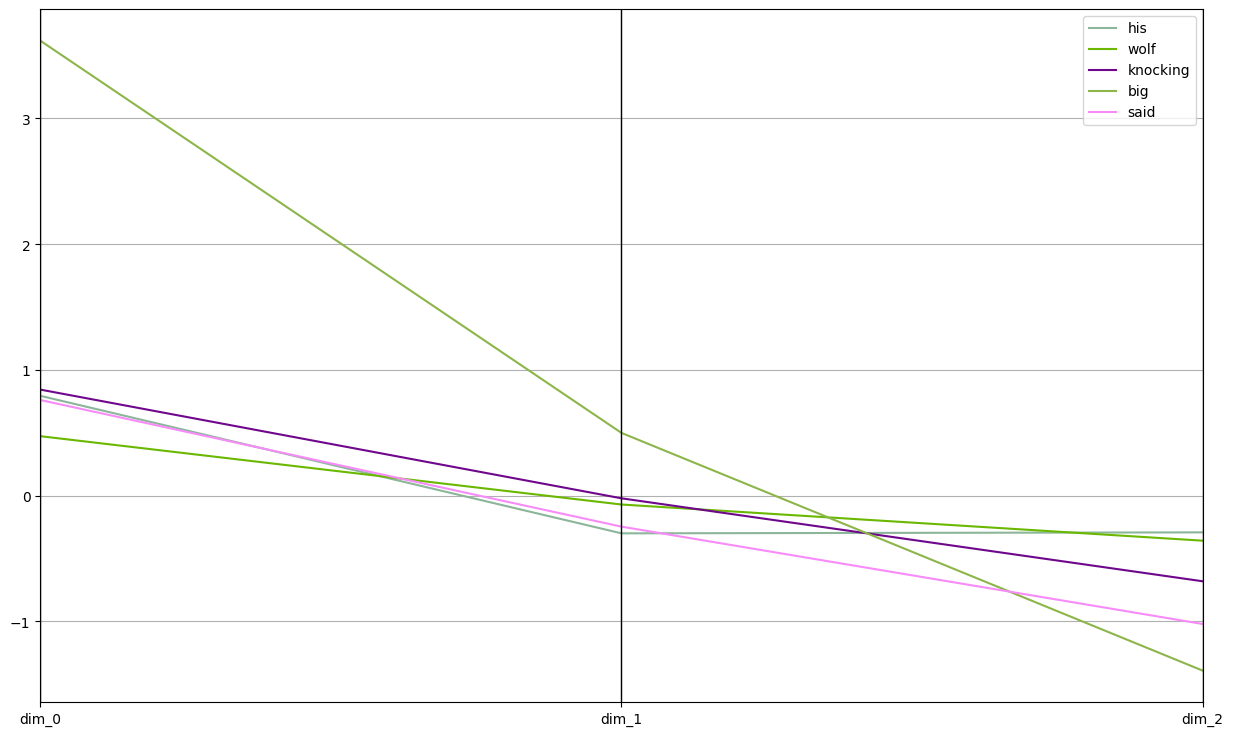

In [20]:
# Find similarities between given word and others
#probe_word = THIS IS DEFINED ALONG WITH DATASET
n = 5

word_embed = word_to_embed(probe_word)

# Build list of similarities between probe_word and rest of words from vocabulary
similarities = []
for word in dict_words:
    similarities.append((word["word"], F.cosine_similarity(word_embed, word["raw_embed"], dim=0)))

print(f"First {n} similarities for \"{probe_word}\":\n{similarities[:n]}\n")

# Sort the list of tuples in descending order based on the values
inverse = [(value, key) for key, value in similarities]
inverse.sort(reverse=True)

# Get the keys corresponding to the n greatest values
top_n_keys = [key for _, key in inverse[:n]]

print(f"Keys corresponding to the {n} greatest values:\n{top_n_keys}\nand least: \"{inverse[-1][1]}\"\n")

# Transpose to DataFrame for plotting
df_words = pd.DataFrame(dict_words)
print("DataFrame:\n", df_words, "\n")

# Plot similarities for probe_word
plt.figure(figsize=(15, 9))  # Adjust the width and height as needed
df_print = df_words.filter(items=['id', 'word', 'dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4']) # plot only first 5 dimensions
parallel_coordinates(df_print[df_print["word"].isin(top_n_keys)].drop(["id"], axis=1), 'word')
#plt.legend(ncol=10)
plt.show()

### Dummy plotting by displaying first 2 dimensions

Plot the first 2 dimensions of the embeddings.

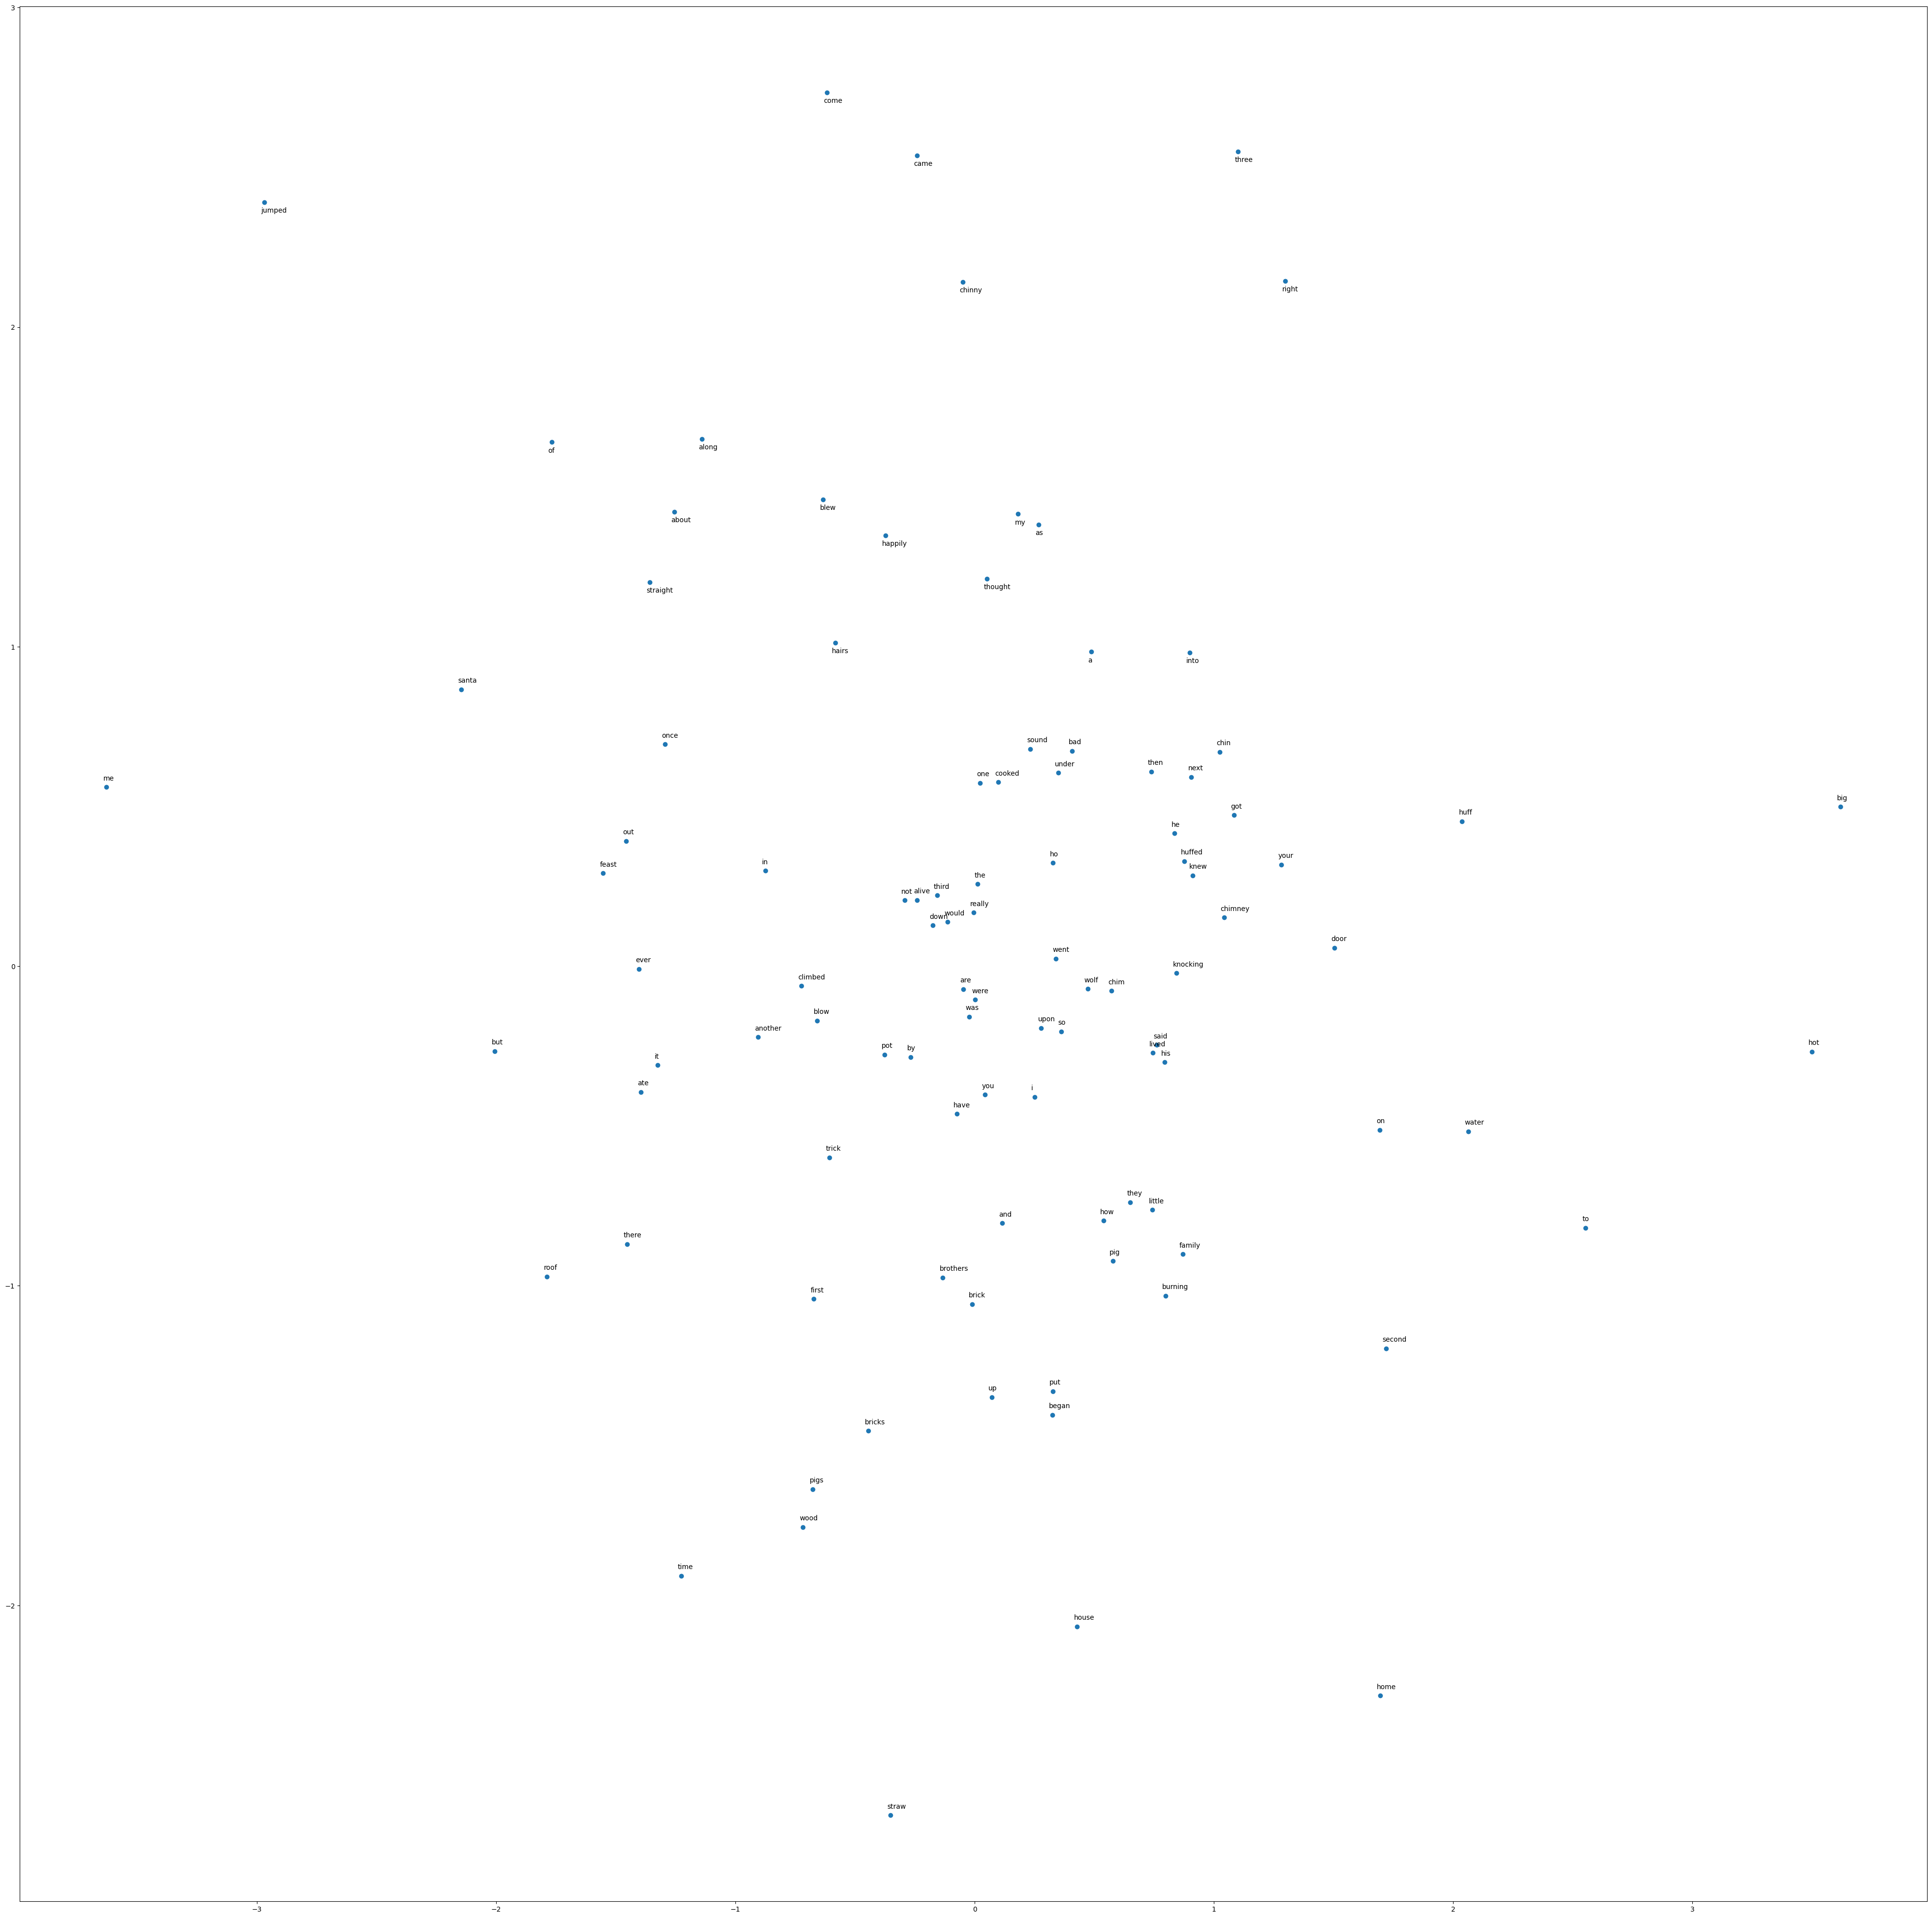

In [21]:
# Pick some words to plot their embeddings
#df_low_dim = df_print[df_print["word"].isin(["Caroline", "went", "school", "Brand", "Stacy", "to", "He"])]
df_low_dim = df_print
# data
data = df_low_dim.drop(["id", "word"], axis=1)
# labels
labels = df_low_dim["word"]

# Plot
fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(1, 1, 1)#, projection='3d')

ax.scatter(data['dim_0'], data['dim_1'])
#parallel_coordinates(df_print[df_print["word"].isin(top_n_keys)].drop(["id"], axis=1), 'word')

# annotator function that draws a label and an arrow
# that points from the label to its corresponding point
def annotate(ax, label, x, y, xytext):
    ax.annotate(label, xy=(x,y),
                xytext=xytext, textcoords='offset points',
                fontsize=10,
                )

# conditionally position labels
for label, x, y in zip(labels, data["dim_0"], data["dim_1"]):
    if y > 0.9:
        annotate(ax, label, x, y, (-5, -15))
    else:
        annotate(ax, label, x, y, (-5, 10))
plt.show()

### Plotting through reduction of dimmensionality using TSNE

(10, 3)


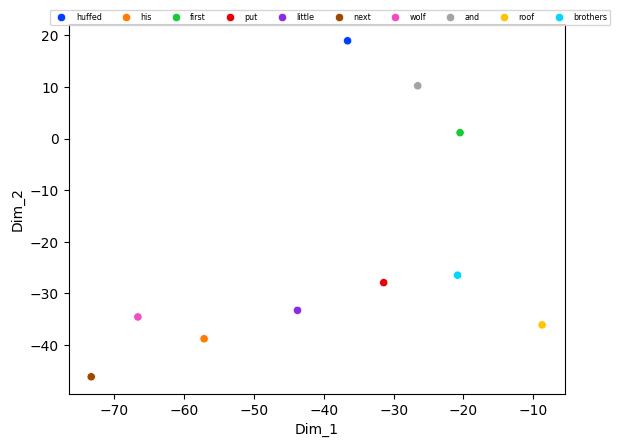

In [22]:

# Importing Necessary Modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns


# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(data)[:10]
print(standardized_data.shape)


# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
#data_1000 = standardized_data[0:1000, :]
#labels_1000 = labels[0:1000]

model_tsne = TSNE(n_components = 2, random_state = 0, perplexity=min(standardized_data.shape[1], 10))
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000

#tsne_data = model_tsne.fit_transform(data)
tsne_data = model_tsne.fit_transform(standardized_data)

# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels[:10])).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))

# Plotting the result of tsne
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label', palette="bright")
plt.legend(fontsize='xx-small', ncol=10, bbox_to_anchor=(1.1, 1.05))
plt.show()